In [1]:
import copy
import os
import random
import shutil
import zipfile
from math import atan2, cos, sin, sqrt, pi, log

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from numpy import linalg as LA
from torch import optim, nn
from torch.utils.data import DataLoader, random_split,TensorDataset
from sklearn.model_selection import train_test_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm
from torchsummary import summary

In [2]:
imageBaseAddress = 'D:\\DataSets\\Pet\\images\\'
maskBaseAddress = 'D:\\DataSets\\Pet\\annotations\\trimaps\\'

transform = transforms.Compose([ transforms.ToTensor(), # normalizes to range [0,1]
                        transforms.Resize([128,128]),
                        transforms.Grayscale()
                       ])
images = []
lables = []
i=0
for subdir, dirs, files in os.walk(imageBaseAddress):
    for file in files:
        im =cv2.imread(imageBaseAddress+file)
        labele =cv2.imread(maskBaseAddress+file.split('.')[0]+'.png')
        labele = (transform(labele)*255).long()
        if(im is not None and labele is not None):    
            images.append(transform(im))
            lables.append(labele)


In [3]:
imagesT = torch.stack(images, dim=0)
lablesT = torch.stack(lables, dim=0)


In [4]:
print(imagesT.shape)
print(lablesT.shape)

torch.Size([7384, 1, 128, 128])
torch.Size([7384, 1, 128, 128])


In [5]:
train_data,test_data, train_labels,test_labels = train_test_split(imagesT, lablesT, test_size=0.2)

# then convert them into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 8
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=batchsize)

In [6]:
del images,lables,imagesT,lablesT,train_data,test_data

In [7]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels,eps=1e-5,momentum=0.1),
            nn.ReLU6(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels,eps=1e-5,momentum=0.1),
            nn.ReLU6(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)

In [8]:
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p

In [9]:
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)
        return self.conv(x)

In [10]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        b = self.bottle_neck(p4)

        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)
        return out

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [12]:
LEARNING_RATE = 3e-4
model = UNet(in_channels=1, num_classes=3)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE,weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [13]:
model

UNet(
  (down_convolution_1): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU6(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_convolution_2): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): B

In [14]:
summary(model.cpu(),(1,128,128),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             640
       BatchNorm2d-2         [-1, 64, 128, 128]             128
             ReLU6-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
             ReLU6-6         [-1, 64, 128, 128]               0
        DoubleConv-7         [-1, 64, 128, 128]               0
         MaxPool2d-8           [-1, 64, 64, 64]               0
        DownSample-9  [[-1, 64, 128, 128], [-1, 64, 64, 64]]               0
           Conv2d-10          [-1, 128, 64, 64]          73,856
      BatchNorm2d-11          [-1, 128, 64, 64]             256
            ReLU6-12          [-1, 128, 64, 64]               0
           Conv2d-13          [-1, 128, 64, 64]         147,584
      BatchNorm2d-14      

In [15]:

tens = torch.tensor((((0,9.1,0),(0,0,9))))
tens2 = torch.rand([8,3,128,128])
labels = torch.randint(0, 3, (8, 1, 128, 128))
print(labels.squeeze().shape)
print(tens2.squeeze().shape)
print(labels)
print(tens2)
lab= torch.tensor((1,2))
criterion(tens2,labels.squeeze())

torch.Size([8, 128, 128])
torch.Size([8, 3, 128, 128])
tensor([[[[2, 0, 2,  ..., 0, 1, 1],
          [1, 0, 0,  ..., 1, 1, 0],
          [1, 0, 0,  ..., 1, 1, 0],
          ...,
          [0, 0, 1,  ..., 2, 1, 1],
          [0, 2, 2,  ..., 2, 0, 1],
          [1, 2, 0,  ..., 1, 0, 0]]],


        [[[1, 1, 1,  ..., 1, 1, 2],
          [0, 2, 2,  ..., 1, 0, 0],
          [2, 2, 2,  ..., 2, 0, 2],
          ...,
          [2, 0, 1,  ..., 0, 1, 1],
          [0, 2, 0,  ..., 2, 2, 2],
          [2, 0, 1,  ..., 1, 2, 2]]],


        [[[0, 2, 2,  ..., 2, 1, 2],
          [1, 0, 1,  ..., 1, 1, 0],
          [0, 1, 0,  ..., 0, 2, 2],
          ...,
          [2, 1, 0,  ..., 1, 1, 1],
          [1, 1, 2,  ..., 1, 1, 2],
          [2, 1, 2,  ..., 1, 0, 2]]],


        ...,


        [[[0, 1, 0,  ..., 1, 1, 1],
          [1, 2, 1,  ..., 0, 2, 0],
          [0, 2, 2,  ..., 0, 1, 1],
          ...,
          [1, 1, 2,  ..., 0, 2, 1],
          [1, 0, 2,  ..., 1, 0, 2],
          [2, 2, 1,  ..., 1, 2

tensor(1.1256)

In [16]:
X, y= next(iter(train_loader))
print(X.shape)
print(y.shape)
yHat = model(X)
print(yHat.shape)
print(y)
loss =  criterion(yHat,y.squeeze())
print(loss)

torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 3, 128, 128])
tensor([[[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]]],


        [[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]]],


        [[[2, 2, 2,  ..., 1, 1, 2],
          [2, 1, 1,  ..., 1, 1, 2],
          [2, 1, 1,  ..., 1, 1, 2],
          ...,
          [1, 1, 1,  ..., 1, 1, 2],
          [1, 1, 1,  ..., 1, 1, 2],
          [1, 1, 1,  ..., 1, 1, 2]]],


        ...,


        [[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]

In [17]:
loss =  criterion(yHat,y.squeeze())
print(loss)

tensor(1.1623, grad_fn=<NllLoss2DBackward0>)


In [18]:
def function2trainTheModel(trainLoader,testLoader,net,optimizer,criterion):

  # number of epochs
  numepochs = 10

  best_valid_Err = 1000
  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  #trainErr  = torch.zeros(numepochs)
  testErr   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchLoss = []
    batchErr  = []
    
    for step,batch in enumerate(trainLoader):
      # push data to GPU
      if step % 50 == 0 and not step == 0:
        print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(trainLoader)))
      X,y = batch
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = criterion(yHat,y.squeeze())

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())
      #batchErr.append( torch.mean((torch.argmax(yHat,axis=1) != y).float()).item() )
    # end of batch loop...

    # and get average losses and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    #trainErr[epochi]  = 100*np.mean(batchErr)



    ### test performance
    net.eval()
    batchAcc = []
    print(f"Eval. train erorr{trainLoss[epochi]}")
    for X,y in testLoader:
      X = X.to(device)
      y = y.to(device)
      # forward pass and loss
      with torch.no_grad():
        yHat = net(X)
      testErr[epochi] = criterion(yHat,y.squeeze()).item()
    if testErr[epochi] < best_valid_Err:
        best_valid_Err = testErr[epochi]
        torch.save(net.state_dict(), 'saved_weights.pt')
    print(f'Finished epoch {epochi+1}/{numepochs}. Test error = {testErr[epochi]:.2f}%')
  # end epochs

  # function output
  return trainLoss,testLoss,testErr,


In [19]:
function2trainTheModel(train_loader,test_loader,model,optimizer,criterion)

  Batch    50  of    738.
  Batch   100  of    738.
  Batch   150  of    738.
  Batch   200  of    738.
  Batch   250  of    738.
  Batch   300  of    738.
  Batch   350  of    738.
  Batch   400  of    738.
  Batch   450  of    738.
  Batch   500  of    738.
  Batch   550  of    738.
  Batch   600  of    738.
  Batch   650  of    738.
  Batch   700  of    738.
Eval. train erorr0.59306800365448
Finished epoch 1/10. Test error = 0.48%
  Batch    50  of    738.
  Batch   100  of    738.
  Batch   150  of    738.
  Batch   200  of    738.
  Batch   250  of    738.
  Batch   300  of    738.
  Batch   350  of    738.
  Batch   400  of    738.
  Batch   450  of    738.
  Batch   500  of    738.
  Batch   550  of    738.
  Batch   600  of    738.
  Batch   650  of    738.
  Batch   700  of    738.
Eval. train erorr0.4527454674243927
Finished epoch 2/10. Test error = 0.43%
  Batch    50  of    738.
  Batch   100  of    738.
  Batch   150  of    738.
  Batch   200  of    738.
  Batch   250  of 

(tensor([0.5931, 0.4527, 0.4031, 0.3714, 0.3461, 0.3263, 0.3124, 0.2923, 0.2807,
         0.2658]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0.4759, 0.4260, 0.3877, 0.3728, 0.3435, 0.4084, 0.3303, 0.3575, 0.3465,
         0.3494]))

In [20]:
model = model.to('cpu')
X, y= next(iter(train_loader))
print(X.shape)
print(y.shape)
yHat = model(X)
print(yHat.shape)
print(y)

torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 3, 128, 128])
tensor([[[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 2, 2, 1],
          [1, 1, 1,  ..., 2, 1, 1],
          [1, 1, 1,  ..., 0, 0, 0]]],


        [[[2, 2, 2,  ..., 1, 1, 1],
          [2, 1, 1,  ..., 1, 1, 1],
          [2, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]]],


        [[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]]],


        ...,


        [[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0]

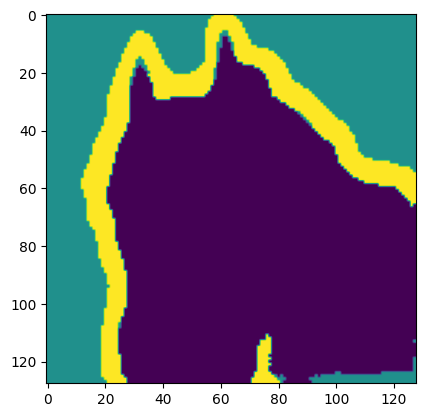

In [21]:
plt.imshow(torch.argmax(yHat,dim=1)[7])

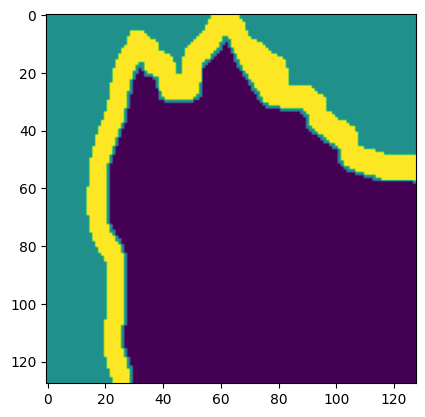

In [22]:
plt.imshow(y[7].squeeze())

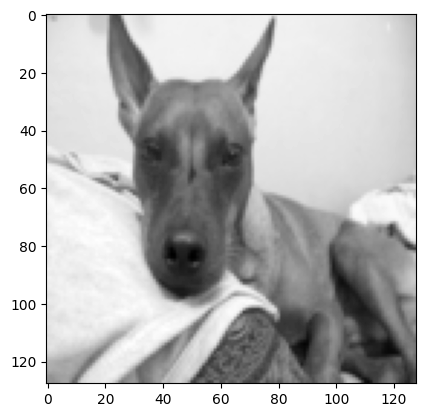

In [23]:
plt.imshow(X[0].squeeze(),cmap='gray')

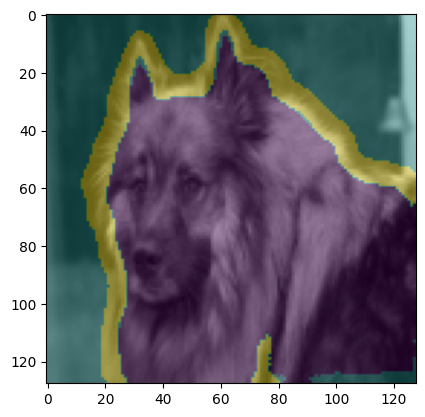

In [24]:
a=7
fig,ax = plt.subplots(1)
ax.set_aspect('equal')
ax.imshow(X[a].squeeze(),cmap='gray')
ax.imshow(torch.argmax(yHat,dim=1)[a].squeeze(),alpha=.4)